In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import random

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
# # Function to create data partitions
# def create_data_partitions(dataset, num_partitions):
#     # Get the number of samples in the dataset
#     num_samples = len(dataset)

#     # Calculate the number of samples per partition
#     samples_per_partition = num_samples // num_partitions

#     # Create a random permutation of indices to shuffle the dataset
#     indices = np.random.permutation(num_samples)

#     data_partitions = {}
#     start_idx = 0

#     # Create data partitions
#     for i in range(num_partitions):
#         end_idx = start_idx + samples_per_partition
#         partition_indices = indices[start_idx:end_idx]

#         # Subset the dataset using the partition indices
#         partition_data = torch.utils.data.Subset(dataset, partition_indices)

#         # Store the partition data in a dictionary
#         data_partitions[f'node{i+1}'] = partition_data

#         start_idx = end_idx

#     return data_partitions

In [84]:
import torch
import numpy as np
from torch.utils.data import Dataset

# Create a custom dataset class to handle data partitioning
class PartitionedDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        # Use the indices to access the data and labels from the original dataset
        dataset_index = self.indices[index]
        data, label = self.dataset[dataset_index]
        return data, label
    
    def update_label(self, index, new_label):
        # Update the label of a specific data point at the given index
        dataset_index = self.indices[index]
        self.dataset.targets[dataset_index] = new_label

def create_data_partitions(dataset, num_partitions):
    # Get the number of samples in the dataset
    num_samples = len(dataset)

    # Calculate the number of samples per partition
    samples_per_partition = num_samples // num_partitions

    # Create a random permutation of indices to shuffle the dataset
    indices = np.random.permutation(num_samples)

    data_partitions = {}
    start_idx = 0

    # Create data partitions
    for i in range(num_partitions):
        end_idx = start_idx + samples_per_partition
        partition_indices = indices[start_idx:end_idx]

        # Create a PartitionedDataset for the partition
        partition_dataset = PartitionedDataset(dataset, partition_indices)

        # Store the partition dataset in a dictionary
        data_partitions[f'node{i+1}'] = partition_dataset

        start_idx = end_idx

    return data_partitions

In [85]:
# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [86]:
images = train_dataset.data
labels = np.array(train_dataset.targets)
np.unique(labels, return_index=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([29,  4,  6,  9,  3, 27,  0,  7,  8,  1]))

In [87]:
num_partitions = 10

# Create data partitions
data_partitions_train = create_data_partitions(train_dataset, num_partitions)

# Example: Print the number of samples in each partition
for node_name, node_data in data_partitions_train.items():
    print(f"{node_name} - Number of samples: {len(node_data)}")

node1 - Number of samples: 5000
node2 - Number of samples: 5000
node3 - Number of samples: 5000
node4 - Number of samples: 5000
node5 - Number of samples: 5000
node6 - Number of samples: 5000
node7 - Number of samples: 5000
node8 - Number of samples: 5000
node9 - Number of samples: 5000
node10 - Number of samples: 5000


In [88]:
# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [68]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.pool2(self.relu2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 64)
        out = self.relu3(self.fc1(out))
        out = self.fc2(out)
        return out

In [69]:
import random
import matplotlib.pyplot as plt

def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * (correct / total)
    return accuracy

def train_local_model(model, model_num, dataloader, testloader, criterion, optimizer, epoch_num, prev_accuracy, target_accuracy=80):
    model.train()
    for epoch in range(1):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        torch.save(model.state_dict(), f'/Users/jithinrajan/Desktop/NTU/FL/model_{model_num}_weights_{epoch_num}.pth')

        # Check accuracy after each epoch and break if target accuracy is reached
        accuracy = get_accuracy(model, testloader)
        training_accuracy = get_accuracy(model, dataloader)
        print(f"Epoch {epoch_num+1}, Loss: {running_loss/len(testloader)}, Test Accuracy: {accuracy}, Train Accuracy: {training_accuracy}, Node: {model_num}")
        
        # if accuracy >= target_accuracy:
        #     print(f"Target accuracy ({target_accuracy}%) achieved for node {epoch_num}.")
        #     break
        if abs(accuracy-prev_accuracy)<0.001:
            print(f'Further training will not improve accuracy.')
            break
    print("\n")
    return accuracy

def federated_learning(data_partitions, testloader, num_epochs, test_node, lr=0.001, target_accuracy=80):
    # models = [Model() for _ in range(10)]
    models = {}
    for i in range(10): 
        models[f'node{i+1}'] = Model()
    average_weights = None
    acc = [0 for _ in range(11)]
    accuracy_track = [[0 for _ in range(num_epochs)] for _ in range(11)]
    ep = 0

    for ep in range (num_epochs):
        model_num = 0
        for node_name, node_data in data_partitions.items():

            model_num+=1
            # Create DataLoader for each node's data
            node_dataloader = DataLoader(node_data, batch_size=32, shuffle=True)
            
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(models[node_name].parameters(), lr=lr)

            # Train local model at the current node
            acc[model_num-1] = train_local_model(models[node_name], model_num, node_dataloader, testloader, criterion, optimizer, ep, acc[model_num-1], target_accuracy=target_accuracy)
            accuracy_track[model_num-1][ep] = acc[model_num-1]

            models[node_name].load_state_dict(torch.load(f'/Users/jithinrajan/Desktop/NTU/FL/model_{model_num}_weights_{ep}.pth'))
            if average_weights is None:
                average_weights = models[node_name].state_dict()
            else:
                for key in average_weights:
                    average_weights[key] += models[node_name].state_dict()[key]
        
        seed = random.randint(1,10)
        print(f'Seed value for this averaging round is {seed}\n')
        
        for key in average_weights:
            average_weights[key] /= 10
        
        for node, model in models.items():
            model.load_state_dict(average_weights)

        for node, model in models.items():
            print(f'Accuracy after avg: {get_accuracy(model, testloader)}\n')
            break
        
        for i in range(10):
            checkpoint_filename = f'/Users/jithinrajan/Desktop/NTU/FL/model_{i+1}_weights_{ep}.pth'
            if os.path.exists(checkpoint_filename):
                os.remove(checkpoint_filename)

    # Initializing plot
    eps = [i+1 for i in range(num_epochs)]
    figure = plt.plot(eps, accuracy_track[test_node-1])
    plot = plt.title("Accuracy vs No. of Epochs", fontsize=20)
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.show()

Epoch 1, Loss: 3.6712361966507343, Test Accuracy: 39.79, Train Accuracy: 42.08, Node: 1


Epoch 1, Loss: 3.663178468052345, Test Accuracy: 42.77, Train Accuracy: 45.9, Node: 2


Epoch 1, Loss: 3.648565313484095, Test Accuracy: 43.75, Train Accuracy: 45.379999999999995, Node: 3


Epoch 1, Loss: 3.5779081688651555, Test Accuracy: 40.949999999999996, Train Accuracy: 44.98, Node: 4


Epoch 1, Loss: 3.6438487089132963, Test Accuracy: 44.64, Train Accuracy: 46.42, Node: 5


Epoch 1, Loss: 3.7029913573325435, Test Accuracy: 42.699999999999996, Train Accuracy: 44.58, Node: 6


Epoch 1, Loss: 3.625343123568764, Test Accuracy: 43.5, Train Accuracy: 45.800000000000004, Node: 7


Epoch 1, Loss: 3.6852068840702876, Test Accuracy: 40.849999999999994, Train Accuracy: 42.14, Node: 8


Epoch 1, Loss: 3.635658499560779, Test Accuracy: 41.370000000000005, Train Accuracy: 44.2, Node: 9


Epoch 1, Loss: 3.6610918467557885, Test Accuracy: 42.809999999999995, Train Accuracy: 44.46, Node: 10


Seed value for 

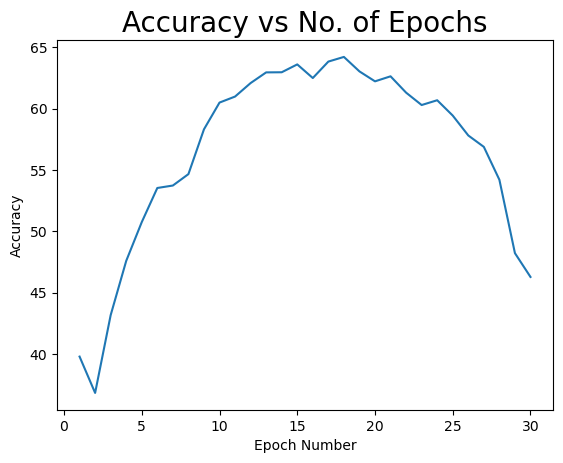

In [70]:
federated_learning(data_partitions_train, test_loader, num_epochs=30, test_node=1, lr=0.001, target_accuracy=80)

In [71]:
# import random
# random.seed(123)
# np.random.seed(123)
# def poison(data_partitions_train, set_number, num_changes_per32=5):
#     num = set_number * 5000
#     node_num = "node" + str(set_number)
#     node_data = data_partitions_train[node_num]

#     # Generating random indices to be changed
#     # random_indices = np.random.choice((num-5000, num), size=num_changes, replace=True)
#     subset_loader = DataLoader(data_partitions_train['node1'], batch_size=32, shuffle=False)
    
#     for img, lbl in subset_loader:
#         l = lbl.tolist()
#         print(lbl)
#         print(l)
#         random_indices = [i for i in range(num_changes_per32)]
#         for i in random_indices:
#             i = i%len(l)
#             shift = random.randint(1,9)
#             modified_label =  (l[i] + shift) % 10
#             l[i] = modified_label
#             lbl = torch.tensor(l)
#         print(lbl)
#         print(l)
#         break
    
#     print(f'Percentage of data poisoned is {num_changes_per32*100/32}%')

In [72]:
import random

def poison(data_partitions_train, set_number, num_changes_per5000 = 100):
    node_num = "node" + str(set_number)
    node_data = data_partitions_train[node_num]
    
    for i in range(num_changes_per5000):
        shift = random.randint(1,9)
        data, label = node_data.__getitem__(i)
        # print(f'old label is {label}')
        modified_label = (label + shift) % 10
        # print(f'new label is {modified_label}')
        node_data.update_label(i, modified_label)
        # data1, label1 = node_data.__getitem__(i)
        # print(f'updated label is {label1}')
    print(f'Percentage of data poisoned is {num_changes_per5000*100/5000}%')

In [73]:
poison(data_partitions_train, set_number=1, num_changes_per5000=2000)

Percentage of data poisoned is 40.0%


In [74]:
# count = 0
# for d, l in data_partitions_train['node1']:
#     print(l)
#     count+=1
#     if count==10:
#         break

Epoch 1, Loss: 4.415449029282678, Test Accuracy: 34.46, Train Accuracy: 25.6, Node: 1


Epoch 1, Loss: 3.6438147840620596, Test Accuracy: 41.94, Train Accuracy: 44.42, Node: 2


Epoch 1, Loss: 3.642122638376453, Test Accuracy: 40.99, Train Accuracy: 42.58, Node: 3


Epoch 1, Loss: 3.6919497915461092, Test Accuracy: 39.47, Train Accuracy: 42.14, Node: 4


Epoch 1, Loss: 3.7105203987676885, Test Accuracy: 37.88, Train Accuracy: 39.46, Node: 5


Epoch 1, Loss: 3.6700501773930805, Test Accuracy: 43.44, Train Accuracy: 45.540000000000006, Node: 6


Epoch 1, Loss: 3.625874439372292, Test Accuracy: 42.88, Train Accuracy: 46.26, Node: 7


Epoch 1, Loss: 3.6698953003823003, Test Accuracy: 43.43, Train Accuracy: 45.58, Node: 8


Epoch 1, Loss: 3.5747942849050593, Test Accuracy: 41.78, Train Accuracy: 46.08, Node: 9


Epoch 1, Loss: 3.6905771207205857, Test Accuracy: 41.010000000000005, Train Accuracy: 42.9, Node: 10


Seed value for this averaging round is 8

Accuracy after avg: 10.0

Epoch 2, L

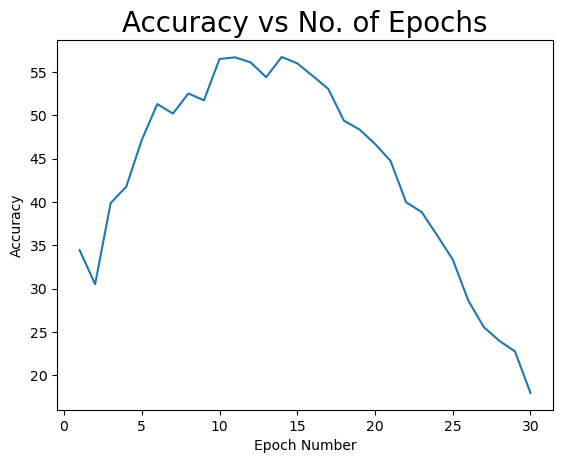

In [75]:
federated_learning(data_partitions_train, test_loader, num_epochs=30, test_node=1, lr=0.001, target_accuracy=80)

In [80]:
poison(data_partitions_train, set_number=1, num_changes_per5000=4000)

Percentage of data poisoned is 80.0%


Epoch 1, Loss: 4.578222751617432, Test Accuracy: 11.16, Train Accuracy: 10.08, Node: 1


Epoch 1, Loss: 3.6240381470209435, Test Accuracy: 39.410000000000004, Train Accuracy: 41.3, Node: 2


Epoch 1, Loss: 3.722097851053069, Test Accuracy: 42.67, Train Accuracy: 45.379999999999995, Node: 3


Epoch 1, Loss: 3.6521868026709257, Test Accuracy: 41.959999999999994, Train Accuracy: 43.94, Node: 4


Epoch 1, Loss: 3.721278616144687, Test Accuracy: 41.69, Train Accuracy: 44.5, Node: 5


Epoch 1, Loss: 3.70431421225584, Test Accuracy: 43.14, Train Accuracy: 44.42, Node: 6


Epoch 1, Loss: 3.6778390739537494, Test Accuracy: 40.36, Train Accuracy: 42.8, Node: 7


Epoch 1, Loss: 3.6922249944904184, Test Accuracy: 39.85, Train Accuracy: 42.08, Node: 8


Epoch 1, Loss: 3.6684239710433575, Test Accuracy: 41.08, Train Accuracy: 42.9, Node: 9


Epoch 1, Loss: 3.609046377713167, Test Accuracy: 40.29, Train Accuracy: 43.28, Node: 10


Seed value for this averaging round is 3

Accuracy after avg: 10.0

Ep

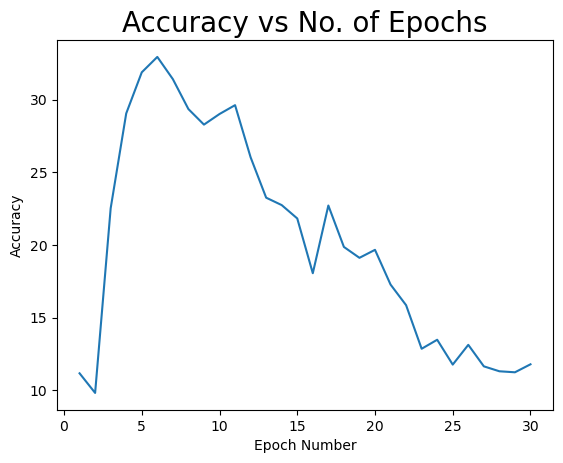

In [81]:
federated_learning(data_partitions_train, test_loader, num_epochs=30, test_node=1, lr=0.001, target_accuracy=80)

In [89]:
poison(data_partitions_train, set_number=1, num_changes_per5000=5000)

Percentage of data poisoned is 100.0%


Epoch 1, Loss: 4.580211413057545, Test Accuracy: 10.0, Train Accuracy: 10.12, Node: 1


Epoch 1, Loss: 3.6492157299307326, Test Accuracy: 41.91, Train Accuracy: 44.86, Node: 2


Epoch 1, Loss: 3.7483737016025978, Test Accuracy: 41.52, Train Accuracy: 44.18, Node: 3


Epoch 1, Loss: 3.7352459325066096, Test Accuracy: 41.71, Train Accuracy: 43.7, Node: 4


Epoch 1, Loss: 3.6622019236600853, Test Accuracy: 42.8, Train Accuracy: 44.34, Node: 5


Epoch 1, Loss: 3.81251059151903, Test Accuracy: 40.2, Train Accuracy: 41.699999999999996, Node: 6


Epoch 1, Loss: 3.6205380068549626, Test Accuracy: 39.379999999999995, Train Accuracy: 42.26, Node: 7


Epoch 1, Loss: 3.687951267520084, Test Accuracy: 41.78, Train Accuracy: 43.8, Node: 8


Epoch 1, Loss: 3.5739464639108394, Test Accuracy: 43.919999999999995, Train Accuracy: 47.54, Node: 9


Epoch 1, Loss: 3.642035190063187, Test Accuracy: 44.5, Train Accuracy: 46.400000000000006, Node: 10


Seed value for this averaging round is 2

Accuracy after a

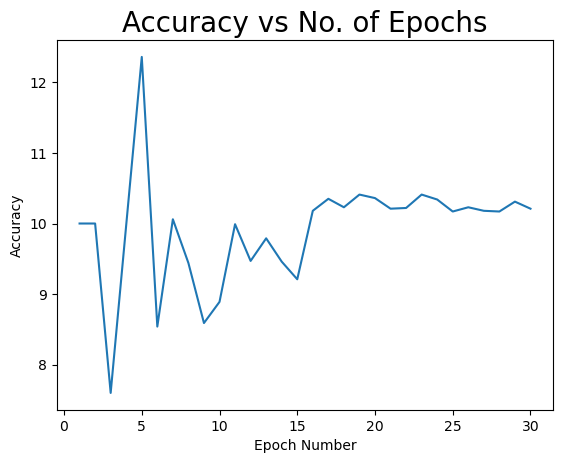

In [90]:
federated_learning(data_partitions_train, test_loader, num_epochs=30, test_node=1, lr=0.001, target_accuracy=80)

In [91]:
from collections import defaultdict
import networkx as nx

class Graph:
    def __init__(self):
        self.graph = defaultdict(list)
        self.node_values = {}
    
    def add_edge(self, u, v, weight):
        self.graph[u].append((v, weight))
        self.graph[v].append((u, weight))

    def connection(self, node1, node2): 
        neighbors = self.graph[node1]
        for v, weight in neighbors:
            if node2==v:
                return True
        return False
    
    def set_node(self, node, value):
        self.node_values[node] = value
    
    def get_node(self, node):
        return self.node_values[node]
        
    def push(self, node, value):
        self.set_node(node, value)
        neighbors = self.graph[node]
        for neighbor, weight in neighbors:
            self.pull(neighbor, value, weight)

    def pull(self, node, value, weight):
        current_value = self.get_node(node)
        if current_value is None or value * weight > current_value:
            self.set_node(node, value * weight)
            neighbors = self.graph[node]
            for neighbor, neighbor_weight in neighbors:
                self.pull(neighbor, value + weight, neighbor_weight)
    
    def pull1(self, node):
        current_value = self.get_node(node)
        if current_value is None:
            return 
        neighbors = self.graph[node]
        for neighbor, weight in neighbors:
            neighbor_value = self.get_node(neighbor)
            if neighbor_value is not None:
                self.set_node(neighbor, neighbor_value + weight)
                self.pull1(neighbor)

    def betweenness_centrality(self):
        G = nx.Graph(self.graph)
        betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
        return betweenness_centrality

    def __str__(self):
        graph_str = ""
        neighbors_dict = {}
        for node in self.graph:
            neighbors = self.graph[node]
            
            neighbors_dict[node] = neighbors
            neighbors_str = ", ".join([f"{v}:{weight}" for v, weight in neighbors])
            value = self.node_values.get(node)
            graph_str += f"{node}:{value} -> {neighbors_str}\n"
        return [graph_str, neighbors_dict]


In [93]:
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def createGraph(graph, nodes, num):
    for i in range(0,num):
        index1 = random.randint(0,9)
        index2 = random.randint(0,9)
        if (index1==index2):
            continue
        if (g.connection(nodes[index1], nodes[index2])==True):
            continue
        weight = random.randint(1,5)
        graph.add_edge(nodes[index1], nodes[index2], weight)

In [94]:
g = Graph()
createGraph(g, nodes, num=15)

In [95]:
graph_struct1 = g.__str__()[1]

track = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print(graph_struct1)

{'I': [('F', 2), ('D', 4)], 'F': [('I', 2), ('H', 2)], 'A': [('J', 4), ('B', 3), ('H', 4)], 'J': [('A', 4), ('E', 2)], 'B': [('A', 3), ('G', 2), ('C', 5)], 'G': [('B', 2), ('D', 1)], 'C': [('B', 5), ('D', 5)], 'H': [('F', 2), ('E', 1), ('A', 4)], 'D': [('I', 4), ('C', 5), ('G', 1)], 'E': [('H', 1), ('J', 2)]}


In [ ]:
def federated_learning_gossip(data_partitions, testloader, num_epochs, test_node, graph_struct, lr=0.001, target_accuracy=80):
    # models = [Model() for _ in range(10)]
    models = {}
    for i in range(10): 
        models[f'node{i+1}'] = Model()
    average_weights = None
    acc = [0 for _ in range(11)]
    accuracy_track = [[0 for _ in range(num_epochs)] for _ in range(11)]
    ep = 0

    for ep in range (num_epochs):
        model_num = 0
        for node_name, node_data in data_partitions.items():

            model_num+=1
            # Create DataLoader for each node's data
            node_dataloader = DataLoader(node_data, batch_size=32, shuffle=True)
            
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(models[node_name].parameters(), lr=lr)

            # Train local model at the current node
            acc[model_num-1] = train_local_model(models[node_name], model_num, node_dataloader, testloader, criterion, optimizer, ep, acc[model_num-1], target_accuracy=target_accuracy)
            accuracy_track[model_num-1][ep] = acc[model_num-1]

            models[node_name].load_state_dict(torch.load(f'/Users/jithinrajan/Desktop/NTU/FL/model_{model_num}_weights_{ep}.pth'))

            # if average_weights is None:
            #     average_weights = models[node_name].state_dict()
            # else:
            #     for key in average_weights:
            #         average_weights[key] += models[node_name].state_dict()[key]
        
        
        seed = random.randint(1,10)
        print(f'Seed value for this averaging round is {seed}\n')
        
        track = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
        track1 = track
        duplicate_graph = graph_struct
        
        i = seed
        while len(track1) != 0:
            k = i+64
            if chr(k) not in track1:
                continue
            node_name_1 = "node"+str(i)
            if average_weights is None:
                average_weights = models[node_name_1].state_dict()
            else: 
                for key in average_weights:
                   average_weights[key] += models[node_name].state_dict()[key]
            print(f'Averaging first done for node {chr(k)}')
            print(f'No. of neighbours for this node is {len(duplicate_graph[track[i-1]])}')
            for j in range (1, len(duplicate_graph[track[i-1]])+1):
                if duplicate_graph[track[i]][j-1][0] not in track1:
                    continue
                node_name_2 = "node"+str(ord(duplicate_graph[track[i-1]][j-1][0])-64)
                for key in average_weights:
                    average_weights[key] += models[node_name_2].state_dict()[key]
                print(f'Averaging second done for node {duplicate_graph[track[i-1]][j-1][0]}')
                
                track1.remove(duplicate_graph[track[i]][j-1][0])
            
            track1.remove(chr(i+64))
            i = (i+1)%10

        for key in average_weights:
            average_weights[key] /= 10
        
        for node, model in models.items():
            model.load_state_dict(average_weights)

        for node, model in models.items():
            print(f'Accuracy after avg: {get_accuracy(model, testloader)}\n')
            break
        
        for i in range(10):
            checkpoint_filename = f'/Users/jithinrajan/Desktop/NTU/FL/model_{i+1}_weights_{ep}.pth'
            if os.path.exists(checkpoint_filename):
                os.remove(checkpoint_filename)

    # Initializing plot
    eps = [i+1 for i in range(num_epochs)]
    figure = plt.plot(eps, accuracy_track[test_node-1])
    plot = plt.title("Accuracy vs No. of Epochs", fontsize=20)
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.show()


In [ ]:
federated_learning_gossip(data_partitions_train, test_loader, num_epochs=2, test_node=1, graph_struct=graph_struct1, lr=0.001, target_accuracy=80)

In [ ]:
# Calculate betweenness centrality
betweenness_centrality = g.betweenness_centrality()

# Print betweenness centrality values
print("\nBetweenness Centrality:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")

In [ ]:
track = [i for i in range(10)]
track.remove(2)
print(track)

In [ ]:
models = {}
for i in range(10): 
    models[f'node{i+1}'] = Model()
average_weights = None
average_weights = models["node1"].state_dict()
print(average_weights.keys())

In [ ]:
def average_values(graph, seed_node):
    # Initialize values for each node
    node_values = {node: 0 for node in graph}
    
    # Initialize the seed node with its original value
    node_values[seed_node] = graph[seed_node]
    
    # Loop until values stabilize
    while True:
        updated_values = {}
        
        for node, edges in graph.items():
            if node == seed_node:
                continue
            
            # Calculate the average value from neighbors
            total_value = sum(node_values[neighbor] for neighbor, _ in edges)
            num_neighbors = len(edges)
            
            if num_neighbors > 0:
                average_value = total_value / num_neighbors
            else:
                average_value = 0  # Handle nodes with no neighbors
            
            updated_values[node] = average_value
        
        # Check if values have stabilized (no changes)
        if updated_values == node_values:
            break
        
        node_values = updated_values.copy()
    
    return node_values

# Your graph
graph = {
    'A': [('G', 4), ('J', 5), ('H', 3), ('F', 2)],
    'G': [('A', 4), ('B', 2)],
    'J': [('F', 4), ('A', 5), ('D', 1), ('I', 1)],
    'F': [('J', 4), ('A', 2), ('D', 1)],
    'I': [('C', 5), ('J', 1)],
    'C': [('I', 5), ('B', 2)],
    'E': [('H', 5)],
    'H': [('E', 5), ('D', 3), ('A', 3)],
    'D': [('H', 3), ('J', 1), ('F', 1)],
    'B': [('G', 2), ('C', 2)]
}

# Choose 'A' as the seed node
seed_node = 'A'

# Perform averaging
averaged_values = average_values(graph, seed_node)

# Print the averaged values
for node, value in averaged_values.items():
    print(f'{node}: {value}')


In [ ]:
track_nos = [i for i in range(1,10)]
print(track_nos)
if 20 not in track_nos:
    print(20)

In [ ]:
ord("A")